<a href="https://colab.research.google.com/github/tahmidjamal12/Classification_models/blob/main/Binary_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating the data

In [ ]:
### 1. Make classification data
import sklearn

from sklearn.datasets import make_circles

#Make 100 samples
n_samples = 1000

#create circles
X, y = make_circles(n_samples,
                   noise=0.05,
                   random_state = 69)

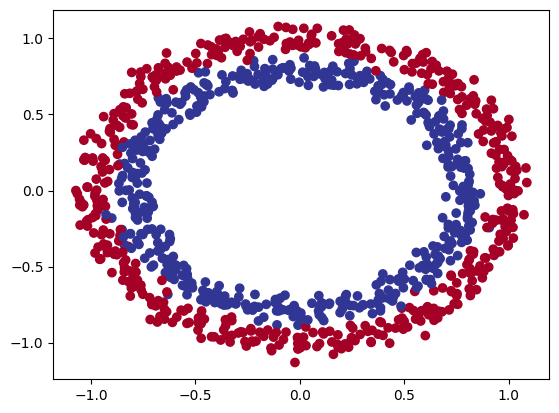

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c = y,
            cmap=plt.cm.RdYlBu)

### Creating Plotting helper functions

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

### Turning data into tensors

In [ ]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

### Splitting the data into test and train splits

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.25, #25% of data will be test date
                                                    random_state=69)

## Building the Model

### Device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Model Class

In [ ]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 16)
    self.layer2 = nn.Linear(16,16)
    self.layer3 = nn.Linear(16, 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = CircleModelV2().to(device)
model_0

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

### optimizer and loss function. Also accuracy function

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), 0.1)

def accurate_fn(x_seen, x_pred):
  correct = torch.eq(x_seen, x_pred).sum().item()
  return (correct/len(x_pred)) * 100

### Training and testing loop

In [ ]:
torch.manual_seed(69)
torch.cuda.manual_seed(69)


X_train, y_train = X_train.to(device),  y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 10000

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accurate_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accurate_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch:  {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch:  0 | Loss:  0.69362 | Acc: 49.33% | Test loss: 0.69101 | Test acc: 52.00%
Epoch:  100 | Loss:  0.68423 | Acc: 61.47% | Test loss: 0.68723 | Test acc: 58.80%
Epoch:  200 | Loss:  0.67649 | Acc: 59.07% | Test loss: 0.68199 | Test acc: 55.20%
Epoch:  300 | Loss:  0.66376 | Acc: 66.27% | Test loss: 0.67201 | Test acc: 63.20%
Epoch:  400 | Loss:  0.64176 | Acc: 72.13% | Test loss: 0.65228 | Test acc: 69.60%
Epoch:  500 | Loss:  0.60200 | Acc: 80.80% | Test loss: 0.61359 | Test acc: 80.00%
Epoch:  600 | Loss:  0.53029 | Acc: 87.60% | Test loss: 0.54005 | Test acc: 88.00%
Epoch:  700 | Loss:  0.41674 | Acc: 95.20% | Test loss: 0.42402 | Test acc: 93.20%
Epoch:  800 | Loss:  0.28753 | Acc: 96.80% | Test loss: 0.29419 | Test acc: 98.00%
Epoch:  900 | Loss:  0.19589 | Acc: 97.33% | Test loss: 0.20182 | Test acc: 98.40%
Epoch:  1000 | Loss:  0.23500 | Acc: 91.07% | Test loss: 0.23190 | Test acc: 90.80%
Epoch:  1100 | Loss:  0.12002 | Acc: 97.73% | Test loss: 0.12753 | Test acc: 98.40%
Epoc

## Plotting Model's Accuracy

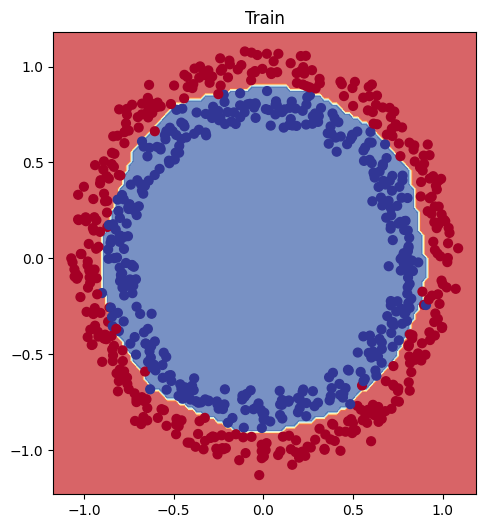

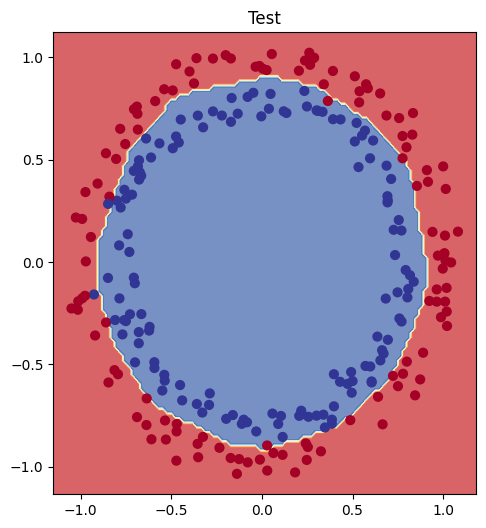

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)